In [1]:
import numpy as np
from numpy.random import seed
import tensorflow as tf

from tensorflow import set_random_seed
seed(42)
set_random_seed(42)

from keras.layers import Input, Dense, TimeDistributed, Embedding
from keras.layers import Concatenate, Reshape, Lambda, Multiply, multiply, concatenate
from keras.models import Model
from keras import backend as K

import matplotlib.pyplot as plt
from matplotlib import style

style.use('seaborn-whitegrid')

def open_pickle(path):
    import pickle
    with open(path, 'rb') as f:
        X = pickle.load(f)
    return X

def load_unigrams(path, X, y):
    word_list = []
    connotation = {}
    
    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            word_list.append(line.strip())
            
    for word in word_list:
        pos_count = 0
        neg_count = 0
        for i, doc in enumerate(X):
            if word in doc.lower():
                
                if (y[i] == 1):
                    pos_count += 1
                else:
                    neg_count += 1
                    
        if pos_count > neg_count:
            connotation[word] = 1
        else:
            connotation[word] = 0
    
    return word_list, connotation

def generate_appearance(X_train_corpus, X_test_corpus, word_list, connotation):
    y_train_agreement = []
    for i in range(len(X_train_corpus)):
        doc_agreement = []
        for word in word_list:
            if word in X_train_corpus[i]:
                if connotation[word] == 1:
                    doc_agreement.append(1)
                else:
                    doc_agreement.append(-1)
            else:
                doc_agreement.append(0)
        y_train_agreement.append(doc_agreement)
        
    y_test_agreement = []
    for i in range(len(X_test_corpus)):
        doc_agreement = []
        for word in word_list:
            if word in X_test_corpus[i]:
                if connotation[word] == 1:
                    doc_agreement.append(1)
                else:
                    doc_agreement.append(-1)
            else:
                doc_agreement.append(0)
        y_test_agreement.append(doc_agreement)
        
    return np.array(y_train_agreement), np.array(y_test_agreement)

# 'imdb-unigrams.txt'

X_train_original = open_pickle('../../data/imdb/imdb_original_preprocessed_xtrain.pickle')
X_test_original = open_pickle('../../data/imdb/imdb_original_preprocessed_xtest.pickle')
y_train_original = open_pickle('../../data/imdb/imdb_original_preprocessed_ytrain.pickle')
y_test_original = open_pickle('../../data/imdb/imdb_original_preprocessed_ytest.pickle')

# Count vectorizer 

from sklearn.feature_extraction.text import CountVectorizer

token = r"(?u)\b[\w\'/]+\b"
cv = CountVectorizer(min_df = 100, token_pattern=token, lowercase=True, binary=True)
X_train = cv.fit_transform(X_train_original)
X_test = cv.transform(X_test_original)

word_list, connotation = load_unigrams('./imdb-unigrams.txt', X_train_original, y_train_original)

y_train_agreement, y_test_agreement = generate_appearance(X_train_original, X_test_original, 
                                                          word_list, connotation)


def history_plot(history, model_name):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
        
    title = model_name + 'accuracy'
    plt.title(title)
    plt.xlabel('epoch')
    plt.legend(['tr_acc', 'val_acc'], loc='upper left')
    plt.show()
    plt.clf()

    plt.plot(history.history['loss'], 'm--')
    plt.plot(history.history['val_loss'], 'y--')

    title = model_name + 'loss'
    plt.title(title)
    plt.xlabel('epoch')
    plt.legend(['tr_loss', 'val_loss'], loc='upper left')
    plt.show()
    plt.clf()

Using TensorFlow backend.


### Test the custom loss

In [2]:
# # https://stackoverflow.com/questions/48951109/keras-custom-binary-cross-entropy-loss-function-get-nan-as-output-for-loss

# def custom_cross_entropy(y_true, y_pred):
#     t_loss = K.max(y_pred,0)-y_pred * y_true + K.log(1+K.exp((-1)*K.abs(y_pred)))
#     return K.mean(t_loss)

# from keras.initializers import Constant, glorot_uniform

# input_layer = Input(shape=(X_train.shape[1],))
# tanh_output = Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=42))(input_layer)
# model = Model(inputs=input_layer, outputs=tanh_output)

# model.compile(loss=custom_cross_entropy,
#              metrics=['acc'],
#              optimizer='adam')

# model.fit(X_train[:16667], y_train_original[:16667], 
#          validation_data=([X_train[16667:], y_train_original[16667:]]),
#          batch_size=1, epochs=1)

In [3]:
# model.evaluate(X_test, y_test_original)

In [4]:
# model.evaluate(X_train, y_train_original)

### 1st model

In [5]:
from keras.initializers import Constant, glorot_uniform

input_layer = Input(shape=(X_train.shape[1],))
tanh_output = Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=42))(input_layer)
model = Model(inputs=input_layer, outputs=tanh_output)

model.compile(loss='binary_crossentropy',
             metrics=['acc'],
             optimizer='adam')

base_history = model.fit(X_train[:16667], y_train_original[:16667], 
                 validation_data=([X_train[16667:], y_train_original[16667:]]),
                 batch_size=1, epochs=10)

Train on 16667 samples, validate on 8333 samples
Epoch 1/10
16667/16667 [==============================] - 110s 7ms/step - loss: 0.3437 - acc: 0.8615 - val_loss: 0.3015 - val_acc: 0.8766
Epoch 2/10
16667/16667 [==============================] - 115s 7ms/step - loss: 0.2364 - acc: 0.9101 - val_loss: 0.2951 - val_acc: 0.8794
Epoch 3/10
16667/16667 [==============================] - 101s 6ms/step - loss: 0.2083 - acc: 0.9213 - val_loss: 0.3099 - val_acc: 0.8733
Epoch 4/10
16667/16667 [==============================] - 119s 7ms/step - loss: 0.1927 - acc: 0.9287 - val_loss: 0.3217 - val_acc: 0.8730
Epoch 5/10
16667/16667 [==============================] - 98s 6ms/step - loss: 0.1809 - acc: 0.9341 - val_loss: 0.3491 - val_acc: 0.8675
Epoch 6/10
16667/16667 [==============================] - 100s 6ms/step - loss: 0.1742 - acc: 0.9361 - val_loss: 0.3462 - val_acc: 0.8722
Epoch 7/10
16667/16667 [==============================] - 108s 6ms/step - loss: 0.1670 - acc: 0.9392 - val_loss: 0.3596 - va

In [6]:
model.evaluate(X_test, y_test_original)

25000/25000 [==============================] - 3s 136us/step


[0.38845316334247587, 0.86528]

In [7]:
model.evaluate(X_train, y_train_original)

25000/25000 [==============================] - 3s 125us/step


[0.21437475922822952, 0.92952]

In [8]:
model.trainable=True

### 2nd model

In [9]:
def layer_split(x):
    return tf.split(x,num_or_size_splits=human_terms_len,axis=1)

def layer_concat(x):
    return tf.concat(x, axis=1)

# build the combined model
# Combined model
human_terms_len = len(word_list)

# base_model = build_base_model(X_train.shape[1])

combined_input_layer = Input(shape=(X_train.shape[1],))

# build the hard coded weight for human terms
ht_input_layer = Input(shape=(human_terms_len,))

# split = Lambda( lambda x: tf.split(x,num_or_size_splits=human_terms_len,axis=1))(ht_input_layer)
split = Lambda(layer_split)(ht_input_layer)

# get the document prediction
label_layer = model(combined_input_layer)
tanh_norm = Lambda(lambda x: (x*2)-1)(label_layer)
# tanh_norm = Lambda(lambda x: tf.scalar_mul(2,x)-1)(label_layer)

# do normalize of bipolar sigmoid


# stack the multiply layer
dense_layer = []
for i in range(human_terms_len):
    dense_layer.append(Dense(1, activation='relu')(Multiply()([split[i], tanh_norm])))

# concat all the result   
# concat = Lambda( lambda x: tf.concat(x, axis=1), name='concatenate')(dense_layer)
concat = Lambda(layer_concat, name='concatenate')(dense_layer)


# pass it to sigmoid layer
output_layer = Dense(1, activation='sigmoid')(concat)

combined_model = Model(inputs=[combined_input_layer, ht_input_layer], outputs=output_layer)
# combined_model.summary()


combined_model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['acc'])

# y_train_tanh = y_train_original
# y_train_tanh[y_train_tanh == 0] = -1

# y_test_tanh = y_test_original
# y_test_tanh[y_test_tanh == 0] = -1

# base_model_history = base_model.fit(X_train[:16667], y_train_original[:16667], 
#                                     validation_data=(X_train[16667:], y_train_original[16667:]),
#                                     batch_size=1, epochs=1)

combined_model_history = combined_model.fit([X_train[:16667],y_train_agreement[:16667]], y_train_original[:16667], 
                                            validation_data=([X_train[16667:], y_train_agreement[16667:]], y_train_original[16667:]),
                                            batch_size=1, epochs=10)

Train on 16667 samples, validate on 8333 samples
Epoch 1/10
16667/16667 [==============================] - 359s 22ms/step - loss: 0.3515 - acc: 0.8670 - val_loss: 0.4592 - val_acc: 0.8261
Epoch 2/10
16667/16667 [==============================] - 298s 18ms/step - loss: 0.2525 - acc: 0.9008 - val_loss: 0.4872 - val_acc: 0.8400
Epoch 3/10
16667/16667 [==============================] - 294s 18ms/step - loss: 0.2312 - acc: 0.9089 - val_loss: 0.5245 - val_acc: 0.8376
Epoch 4/10
16667/16667 [==============================] - 282s 17ms/step - loss: 0.2199 - acc: 0.9151 - val_loss: 0.5491 - val_acc: 0.8364
Epoch 5/10
16667/16667 [==============================] - 277s 17ms/step - loss: 0.2070 - acc: 0.9180 - val_loss: 0.5847 - val_acc: 0.8364
Epoch 6/10
16667/16667 [==============================] - 279s 17ms/step - loss: 0.2021 - acc: 0.9204 - val_loss: 0.6090 - val_acc: 0.8386
Epoch 7/10
16667/16667 [==============================] - 280s 17ms/step - loss: 0.1962 - acc: 0.9219 - val_loss: 0.6

In [10]:
combined_model.evaluate([X_test, y_test_agreement], y_test_original)

25000/25000 [==============================] - 6s 247us/step


[0.7139036497330665, 0.83008]

In [11]:
combined_model.evaluate([X_train, y_train_agreement], y_train_original)

25000/25000 [==============================] - 7s 278us/step


[0.34807942066431047, 0.89788]

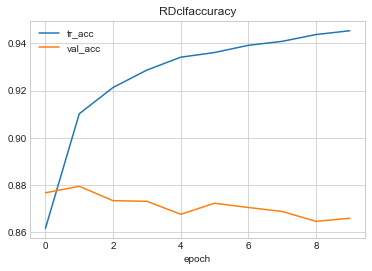

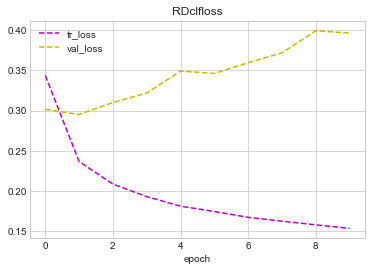

<Figure size 432x288 with 0 Axes>

In [12]:
history_plot(base_history,'RDclf')

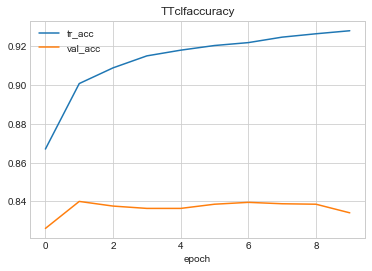

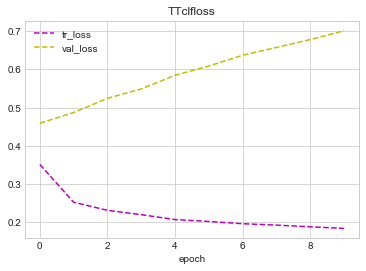

<Figure size 432x288 with 0 Axes>

In [13]:
history_plot(combined_model_history,'TTclf')